---

 # <center><span style="color:red">Práctica 1: Lectura y exploración inicial de datos.</span></center>

---

In [3]:
# Librerías necesarias para realizar la práctica
# -----------------------------------------------------
# Manipulación y lectura de datos
import netCDF4 as nc
import pandas as pd
import xarray as xr
import numpy as np
from datetime import timedelta,datetime

# Estadistica
from scipy import stats

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
sns.set_style('whitegrid')

import math
import warnings
warnings.filterwarnings('ignore')

<p style="text-align: justify;"></p>

## <span style="color:green">Apartado 1</span>:   
<span style='color:black'>Análisis de la temperatura media diaria de la superficie en Barajas. En este apartado se pretende analizar el ciclo estacional y más en particular dos meses: enero y julio, con tres bases de datos diferentes para poder intercomparar los resultados. También se prentende comparar si ha habido un cambio en la temperatura a lo largo del periodo disponible y si las bases de datos son comparables.</span>

### <span style='color:darkgreen'>1.1. Datos de estación</span>

<span style='color:black'>A la estación de Barajas le corresponde el código 08221099999. Descargaremos los datos que corresponden a esa estación.</span>

In [2]:
# Necesito sabes la latitud y longitud de la estación de Barajas
estacion = 'BARAJAS'

# Voy a intentar conseguir el código de la estación para ello necesito leer 
# el siguiente archivo
informacion = 'data/isd-history.csv'

df_codigos = pd.read_csv(informacion)
barajas = df_codigos[df_codigos['STATION NAME']==estacion]

# Voy a conseguir el código de barajas a ver si es el mismo que el 
# proporcionado por Belén
codigo = str(barajas['USAF'].values[0]) + '-' + str(barajas['WBAN'].values[0])

print(f'Seleccionada la estacion {estacion.capitalize()} con código {codigo}')

Seleccionada la estacion Barajas con código 082210-99999


<span style='color:black'>El código proporcionado por Belén y obtenido de los datos es el mismo, asi que procedo a descargarme los datos con el código proporcionado por Belen en las anteriores clases de la asignatura.</span>

In [3]:
# Definimos las columnas y el tipo de dato que va a tener el DataFrame donde vamos a alojar los datos de la estación
colNames = ['year','month','day','hour','temp','tempd','slp','windDir','windSpeed','cloud','pcp1h','pcp6h']
dataType = ['int','int','int','int',np.float64,'float','float','float','float','float','float','float',]

# Definimos los límites de los caractéres donde están los datos en los archivos que vamos a leer 
# (Esta información está en: https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt)

# D: de la página sacamos las posiciones en el str en la que está cada tipo de datos (cada columna) y la pasamos:
limits = [(0,4),(5,7),(8,10),(11,13),(14,19),(20,25),(26,31),(32,37),(38,43),(44,49),(50,55),(56,61)] 
yearInit = 1973
yearEnd  = 2020

# lectura de los datos:
concat_list = []
for iyr in range(yearInit, yearEnd, 1):
    # Descomentar la siguiente línea si se prefiere hacer lectura directamente desde el servidor (lento)
    fil = 'https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/'+str(iyr)+'/'+codigo +'-'+ str(iyr)+'.gz'
    # si tuvieras los datos en una carpeta, pondrias el path y el nombre de la estación
    # fil=path + station+'-'+str(iyr)+'.gz'
    data = pd.read_fwf(fil,sep=' ',compression='gzip',head=0,
                     names=colNames, colspecs=limits)
    
    # data_array = np.concatenate((data_array,data.values),axis=0)
    # df = df.append(data) # Esto ya no se usa, no le gusta a Python, dice que lo cambie por concat
    concat_list.append(data)
    
df = pd.concat(concat_list)

dictTpe = dict(zip(colNames,dataType))

isd_data = df.replace(-9999, np.NaN)
isd_data = isd_data.astype(dictTpe, copy=True)

# Datos cada: 6h 

In [4]:
# Voy a poner de índice la fecha en datetime
def get_datetime_index(df: pd.DataFrame) -> pd.DataFrame:
    
    """_summary_

    Args:
        df (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    
    cols=['year', 'month', 'day']
    df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), 
                                axis="columns")
    	
    df['date']=pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return df[['temp']]

In [5]:
df_reformed = get_datetime_index(isd_data)

#### <span style='color:darkblue'>1.1.1. Caracterización del ciclo estacional</span>

In [6]:
# This are the columns I want to play with
columns = ['year', 'month', 'day', 'hour', 'temp']
isd_data = isd_data[columns]

# Están multiplicados por 10 los datos de temperatura
# isd_data['temp'] /= 10 

In [7]:
# Nombre de los meses
months= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
         'September', 'October', 'November', 'December']

# Números de meses
number_months = list(range(1,13))

# Diccionario con contiene si número de mes y su nombre
months_dic = dict(zip(number_months, months))

In [8]:
# Los datos están multiplicados por 10 
isd_data['temp'] = isd_data['temp']/10

Text(0.5, 1.0, 'Ciclo Estacional')

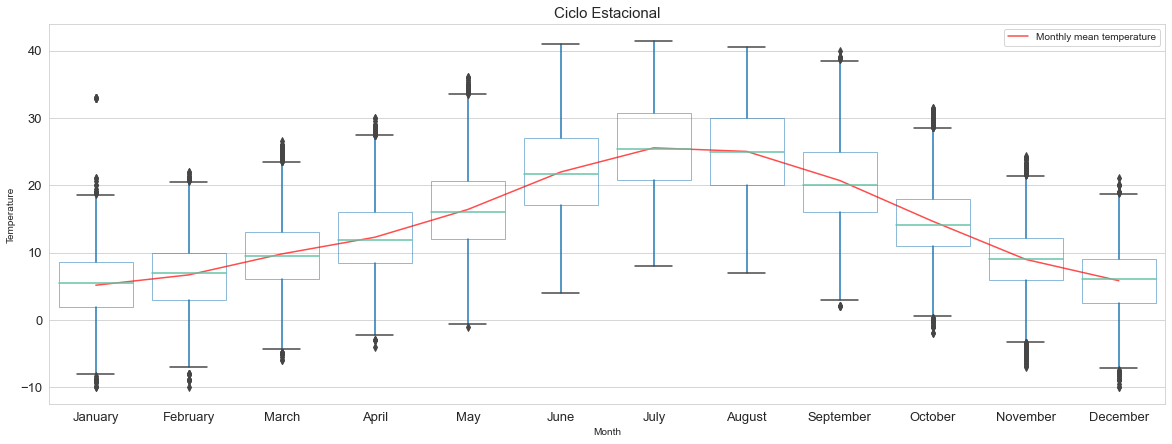

In [9]:
plt.figure(figsize=(20,7))
sns.boxplot(data = isd_data, x='month', y='temp', boxprops={"facecolor": "None", "edgecolor": sns.color_palette("Paired")[1],
                          "linewidth": 0.5},
            medianprops ={'color':sns.color_palette("Set2")[0]},
            whiskerprops={'color':sns.color_palette("Paired")[1]})

plt.plot(np.arange(0,12), isd_data.groupby(['month'], dropna=True).mean()['temp'], color='red', alpha=0.7, label='Monthly mean temperature')

plt.legend(loc='best')
plt.ylabel('Temperature')
plt.xlabel('Month')
plt.xticks(np.arange(12),months_dic.values(), size=13)
plt.yticks(np.arange(-10,50,10), size=13)
plt.title('Ciclo Estacional',fontsize=15)

#### <span style='color:darkblue'>1.1.2 Caracterización de la distribución para enero y julio</span>

<div span style='color:black'>
<li> Dibuja el histograma con todos los datos para cada mes.</li>
<li> Haz un ajuste a la distribución normal (recuerda lo visto en el tema 2 de estimación puntual de
parámetros).</li>
<li> Calcula los percentiles 5% y 95% para enero y julio separadamente tanto de la distribución
empírica (en Python puedes emplear la función quantile del paquete de numpy), como empleando el
ajuste (en Python, en el módulo stats tienes stats.norm.ppf() que te puede ayudar).</li>
<li>  Calcula el intervalo de confianza para la media con un nivel de confianza del 95% para enero y
julio separadamente. (En Python, recuerda que tienes stats.norm.ppf() para ayudarte).</li>
<li>  Comenta todos los resultados.</li>
</div>


Stadistic data from January
Percentiles for the data in January are: q(5%)=-2.80 and q(95%)= 12.30
Percentiles for the theoric distribution in January are: q(5%)=-2.54 and q(95%)= 12.82
IC= [5.14+-0.05] (ºC)
With scipy function:(5.090559651080425, 5.193808356080203)
------------------------------------------------------------------------------
Stadistic data from July
Percentiles for the data in July are: q(5%)=16.00 and q(95%)= 35.40
Percentiles for the theoric distribution in July are: q(5%)=15.37 and q(95%)= 35.73
IC= [25.55+-0.07] (ºC)
With scipy function:(25.480856441364992, 25.61889964826404)
------------------------------------------------------------------------------


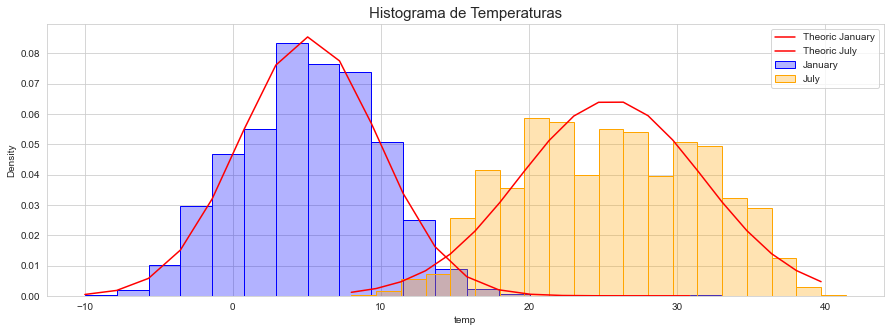

In [10]:
plt.figure(figsize=(15,5))

meses = [1,7]
colores = ['blue', 'orange']
for i in meses:
    # Creo una variable con los datos que quiero representar
    data = isd_data[isd_data['month']==i]['temp']

    # Plot de histograma
    sns.histplot(data=data,color=colores[meses.index(i)], stat='density',
                bins=20, alpha=0.3, edgecolor=colores[meses.index(i)], label=months_dic[i])

    # Distribución normal sobre el histograma
    mean = data.mean()
    std  = data.std()
    n= np.shape(data)[0]
    bins= np.arange(np.min(data),np.max(data),step=(np.max(data)-np.min(data))/20) 
    normal_distribution= stats.norm.pdf(bins,mean,std)
    
    plt.plot(bins,normal_distribution,'red',label=f'Theoric {months_dic[i]}')

    # Calculo de quantiles
    quantile_theoric = [stats.norm.ppf(0.05,mean,std),stats.norm.ppf(0.95,mean,std)]
    
    # Print de los datos que tengo en los percentiles
    print(f'Stadistic data from {months_dic[i]}')
    print(f'Percentiles for the data in {months_dic[i]} are: q(5%%)=%.2f and q(95%%)= %.2f' %(data.quantile(q=0.05), data.quantile(q=0.95)))
    print(f'Percentiles for the theoric distribution in {months_dic[i]} are: q(5%%)=%.2f and q(95%%)= %.2f' %(quantile_theoric[0],quantile_theoric[1]))

    
    # Intervalo de confianza del 95%
    alfa=0.05
    
    # We must use the t-student distribution, beacuse with don't now the standard deviation of the data
    t_alpha_2= stats.t.ppf(1-alfa/2,n-1)
    ic= t_alpha_2*std/np.sqrt(n)
    print('IC= [%.2f+-%.2f] (ºC)'%(mean,ic))

    ic_scipy=stats.t.interval(alpha=0.95, df=n-1, loc=mean, scale=std/np.sqrt(n))
    print(f'With scipy function:{ic_scipy}')
    
    print('------------------------------------------------------------------------------')
    
# Cosas globales que quiero representar en el gráfico
plt.title('Histograma de Temperaturas',fontsize=15)
plt.legend()

#### <span style='color:darkblue'>1.1.3 Cambio climático</span>

<span style='color:black'>Calcula la media de la temperatura en enero y julio para el periodo 1973-
1989. Calcula la desviación típica de la temperatura en enero y julio para el periodo 1973-1989 y el
periodo 1990-2019. Haz los contrastes de hipótesis pertinentes para decir si ha cambiado
significativamente la temperatura en Barcelona en ambos periodos.</span>

In [11]:
# Voy a hacer una clase para los tests estadísticos

class StadisticalTests():
    # El método __init__ incluye toda la lógica necesaria para los índices de entrada y etiqueta.
    def __init__(self, x, y, alpha) -> None:
        
        self.x     = x
        self.y     = y
        self.alpha = alpha
   
    def f_test_stats(self) -> float:
        """
            Metodo que calcula el resultado p del test de Fisher para las varianzas, utilizando funciones de scipy.stats.

        Returns:
            float: el valor p. Si nuestro alpha que solemos determinarlo en 0.05, es mayor que p entonces nuestra hipotesis se acepta
                   en cambio, si el manor, debemos rechazar la hipotesis realizada.
        """
        
        # Cálculo del estadístico
        f = np.var (self.x, ddof = 1) /np.var (self.y, ddof = 1)
        
        # Calculo de la p si esta es menor que 0.05 la aceptamos
        p = 1- stats.f.cdf (f, self.x.size-1, self.y.size-1) 
        return p
    
    def _f_fisher(self):
   
        n1 = self.x.size
        n2 = self.y.size
        
        f = stats.f.interval(self.alpha, n1, n2, loc=0, scale=1)
        return f
    
    def f_test_manual(self) -> bool:
        """
            Otro método para calcular el test de Fisher pero esta vez implementado de manera manual.
        
        Returns:
            bool: si el estadístico calculado, f , está dentro de nuestro intervalo de significancia
                devolvemos True sino False.
        """
        # Cálculo del estadístico
        f = np.var (self.x, ddof = 1) /np.var (self.y, ddof = 1)
        f=1 # porque suponemos que son iguales
        
        # Intervalo de significancia con el alpha que hemos determinado
        isig = self._f_fisher()
        
        # Aceptamos o no la hipotesis?
        if f > isig[0] and f<isig[1]:
            print(f'Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de {self.alpha}.')
            return True
        else:
            print(f'Se ha rechazado la hipotesis de que las varianzas son iguales con una confianza de {self.alpha}.')
            return False
    
    def _z(self):
        
        z = abs(np.mean(self.x) - np.mean(self.y)) / np.sqrt(np.var(self.x,ddof=1) / self.x.size + np.var(self.y,ddof=1) / self.y.size)
        return z

    def mean_test(self) -> bool:
        # Calculo valor con el que voy a comparar mi muestra
        z_alpha_2 = stats.norm.ppf(1-self.alpha/2)
    
        z = self._z()
        
        if z <= z_alpha_2:
            # Se acepta la hipotesis
            print(f'Se ha aceptado la hipotesis de que las medias son iguales con una confianza de {self.alpha}.')
            # return True
        else:
            # Se anula la hipotesis
            print(f'Se ha rechazado la hipotesis de que las medias son iguales con una confianza de {self.alpha}.')
            # return False
        
    def mean_test_stats(self):

        return stats.ttest_ind(self.x, self.y, nan_policy='omit', equal_var=False)
    #     A p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that
    # our observation is not so unlikely to have occurred by chance. Therefore,
    # we do not reject the null hypothesis of equal population means.
    # If the p-value is smaller than our threshold, then we have evidence
    # against the null hypothesis of equal population means.
    
    # El 5% quiero dejarlo fuera, lo de dentro son igualsi lo rechazo me entra dentro en
    # el p-value
    

In [12]:
# Primer periodo
#===============================================================================
isd_data_first = isd_data[(isd_data.year>1973) & (isd_data.year<1990)]

# Meses seleccionados
enero_first = isd_data_first[isd_data_first.month == 1]['temp']
julio_first = isd_data_first[isd_data_first.month == 7]['temp']


# Segundo periodo
#================================================================================
isd_data_last = isd_data[(isd_data.year>1990) & (isd_data.year<2020)]


# Meses seleccionados
enero_last = isd_data_last[isd_data_last.month == 1]['temp']
julio_last = isd_data_last[isd_data_last.month == 7]['temp']

In [13]:
# Enero
alpha = 0.05
a = StadisticalTests(x=julio_first, y=julio_last, alpha  = alpha)
b = StadisticalTests(x=enero_first, y=enero_last, alpha = alpha)

In [14]:
# Para julio
a.mean_test()
a.f_test_manual()
a.f_test_stats()
a.mean_test_stats()

# Enero
b.mean_test()
b.f_test_manual()
b.f_test_stats()
b.mean_test_stats()

Se ha rechazado la hipotesis de que las medias son iguales con una confianza de 0.05.
Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de 0.05.
Se ha rechazado la hipotesis de que las medias son iguales con una confianza de 0.05.
Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de 0.05.


Ttest_indResult(statistic=-5.701411984511553, pvalue=1.2025924971506797e-08)

### <span style='color:darkgreen'>1.2.  Análisis con datos de la base CPC de temperatura global diaria.</span>

#### <span style='color:darkblue'>1.2.1 Caracterización del ciclo estacional</span>

In [15]:
def get_index(df:pd.DataFrame, lat:np.array, lon:np.array)->tuple:
    """
        _summary_

    Args:
        df (pd.DataFrame): DataFrame donde tengo la información de la estación
        lat (np.array): todos los datos de latitud que tengo dentro del netCDf
        lon (np.array): todos los datos de longitud que tengo dentro del netCDf

    Returns:
        tuple: _description_
    """
    
    lat_barajas = float(barajas['LAT'])
    lon_barajas = float(barajas['LON'])

    lat_dif = (lat-lat_barajas)**2
    lon_dif = (lon-lon_barajas)**2

    # Los convierto en lista ya que así encuentro fácilmente su index
    lat_dif = lat_dif.tolist()
    lon_dif = lon_dif.tolist()

    # Consigo los ídices estos siendo el valor mínimo de la diferencia cuadrada
    index_lat = lat_dif.index(min(lat_dif))
    index_lon = lon_dif.index(min(lon_dif))
    
    return index_lat, index_lon

In [16]:
def convert_data(data:any) -> list:
    """
        Función para convertir los datos de fecha de formato timedelta de horas a un string con fechas legibles.

    Args:
        data (any): objeto nc.Dataset donde tenemos los datos mensuales de temperatura para todas las latitudes y longitudes

    Returns:
        list: las fechas en formato str de los datos de tiempo dentro de ese nc.Dataset
    """
    time = data.variables['time'][:]

    # El formato en el que tenemos dado el tiempo no nos sirve asique vamos a cambiarlo
    # data.variables['time'].units -> 'hours since 1900-01-01 00:00:00'
    dates = []
    
    for data_indays in time:
        specific_data = datetime(1900,1,1,0,0,0)
        new_date = str(specific_data + timedelta(hours=int(data_indays)))
        dates.append(new_date)
        
    return dates

In [17]:
# Voy a hacerlo con los datos de CPC_global_daily
folder = 'CPC_global_daily'

# Creo un pandas dataframe vacio
df_list=[]
for mes in range(1,13):
    data = nc.Dataset(f'data/{folder}/tmean_PI_mes_{mes}.nc')
    
    lon = data.variables['lon'][:]
    lat = data.variables['lat'][:]
    
    # Ahora ya obtendo los datos y los almaceno en un pandas DataFrame
    # [time, lat,lon]
    index_lat,index_lon = get_index(barajas, lat, lon)
    tmean = data.variables['tmean'][:,index_lat,index_lon]
    
    dates = convert_data(data)
    df = pd.DataFrame(data={f'{mes}':tmean}, index = dates)
    df.index.name = 'date'
    df.index = pd.to_datetime(df.index)
    df_list.append(df)

Text(0.5, 1.0, 'Ciclo Estacional')

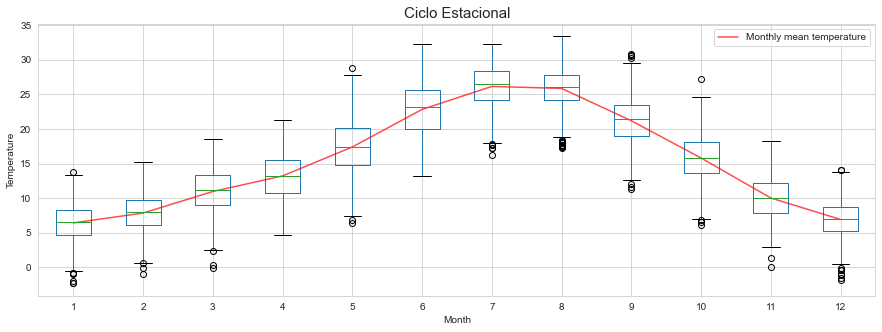

In [18]:
df_1=pd.concat(df_list, axis=1)

df_1.boxplot(figsize=(15,5))
plt.plot(list(range(1,13)), df_1.mean(), color='red',alpha=0.7,
         label = 'Monthly mean temperature')

plt.legend(loc='best')
plt.ylabel('Temperature')
plt.xlabel('Month')
plt.title('Ciclo Estacional',fontsize=15)

#### <span style='color:darkblue'>1.2.2 Caracterización de la distribución para enero y julio</span>

orange
Stadistic data from January
Percentiles for the data in January are: q(5%)=1.92 and q(95%)= 10.50
Percentiles for the theoric distribution in January are: q(5%)=2.03 and q(95%)= 10.83
IC= [6.43+-0.17] (ºC)
With scipy function:(6.2555134923417315, 6.599763569120671)
------------------------------------------------------------------------------
blue
Stadistic data from July
Percentiles for the data in July are: q(5%)=20.59 and q(95%)= 30.33
Percentiles for the theoric distribution in July are: q(5%)=21.25 and q(95%)= 31.03
IC= [26.14+-0.19] (ºC)
With scipy function:(25.951985645113922, 26.33461637514975)
------------------------------------------------------------------------------


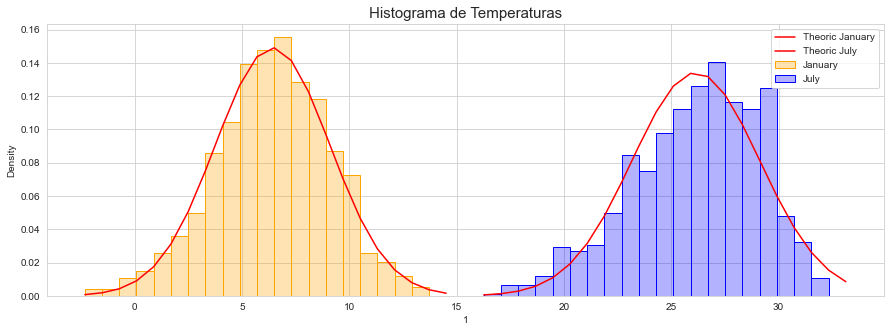

In [19]:
plt.figure(figsize=(15,5))

meses = [1,7]
colores = ['orange', 'blue']

for i in meses:
    # Creo una variable con los datos que quiero representar
    data = df_list[i-1][f'{i}']

    # Plot de histograma
    sns.histplot(data=data,color=colores[meses.index(i)], stat='density',
                bins=20, alpha=0.3, edgecolor=colores[meses.index(i)], 
                label = months_dic[i])
    print(colores[meses.index(i)])

    # Distribución normal sobre el histograma
    mean = data.mean()
    std  = data.std()
    n= np.shape(data)[0]
    
    minim = data.min()
    maxim = data.max()
    
    bins= np.arange(minim, maxim+1, step = (maxim - minim)/20) 
    
    normal_distribution= stats.norm.pdf(bins,mean,std)
    
    # Plot de la normal
    plt.plot(bins,normal_distribution,'red',label=f'Theoric {months_dic[i]}')

    # Calculo de quantiles
    quantile_theoric = [stats.norm.ppf(0.05,mean,std),
                        stats.norm.ppf(0.95,mean,std)]
    
    # Print de los datos que tengo en los percentiles
    print(f'Stadistic data from {months_dic[i]}')
    print(f'Percentiles for the data in {months_dic[i]} are: q(5%%)=%.2f and q(95%%)= %.2f' %(data.quantile(q=0.05), data.quantile(q=0.95)))
    print(f'Percentiles for the theoric distribution in {months_dic[i]} are: q(5%%)=%.2f and q(95%%)= %.2f' %(quantile_theoric[0],quantile_theoric[1]))

    
    # Intervalo de confianza del 95%
    alfa=0.05
    
    # We must use the t-student distribution, beacuse with don't now 
    # the standard deviation of the data
    t_alpha_2= stats.t.ppf(1-alfa/2,n-1)
    ic= t_alpha_2*std/np.sqrt(n)
    print('IC= [%.2f+-%.2f] (ºC)'%(mean,ic))

    ic_scipy=stats.t.interval(alpha=0.95, df=n-1, loc=mean, scale=std/np.sqrt(n))
    print(f'With scipy function:{ic_scipy}')
    
    print('------------------------------------------------------------------------------')
    
# Cosas globales que quiero representar en el gráfico
plt.title('Histograma de Temperaturas',fontsize=15)
plt.legend()

#### <span style='color:darkblue'>1.2.3 Análisis de la consistencia entre los datos de estación y del CPC Para enero y julio separadamente evalúa la consistencia de los datos.</span>

In [20]:
# Datos de CPC para enero
# Lo de ['numero'] lo pongo para que la salida sean un pandas series 
# y no dataframe
df_enero = df_list[0]['1']
df_julio = df_list[6]['7']

# Datos de la estacion
estacion_enero = isd_data[isd_data.month == 1]['temp']
estacion_julio = isd_data[isd_data.month == 7]['temp']

In [21]:
# Enero
alpha = 0.05
a = StadisticalTests(x=df_enero, y=estacion_enero, alpha  = alpha)
b = StadisticalTests(x=df_julio, y=estacion_julio, alpha = alpha)

In [22]:
# Enero
a.f_test_manual()
a.mean_test()

Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de 0.05.
Se ha rechazado la hipotesis de que las medias son iguales con una confianza de 0.05.


### <span style='color:darkgreen'>1.3.  Análisis con datos de la base NCEP/NCAR</span>

#### <span style='color:darkblue'>1.3.1 Caracterización del ciclo estacional.</span>

In [23]:
# Voy a hacerlo con los datos de CPC_global_daily
folder = 'NCEP-NCAR'

# Creo un pandas dataframe vacio
df_list=[]
for mes in range(1,13):
    data = nc.Dataset(f'data/{folder}/NCEP_NCAR_air_PI_mes_{mes}.nc')
    
    lon = data.variables['lon'][:]
    lat = data.variables['lat'][:]
    
    # Ahora ya obtendo los datos y los almaceno en un pandas DataFrame
    # [time, lat,lon]
    index_lat,index_lon = get_index(barajas, lat, lon)
    air = data.variables['air'][:,index_lat,index_lon]
    
    dates = convert_data(data)
    df = pd.DataFrame(data={f'{mes}':air}, index = dates)
    df.index.name = 'date'
    df.index = pd.to_datetime(df.index)
    df_list.append(df)

Text(0.5, 1.0, 'Ciclo Estacional')

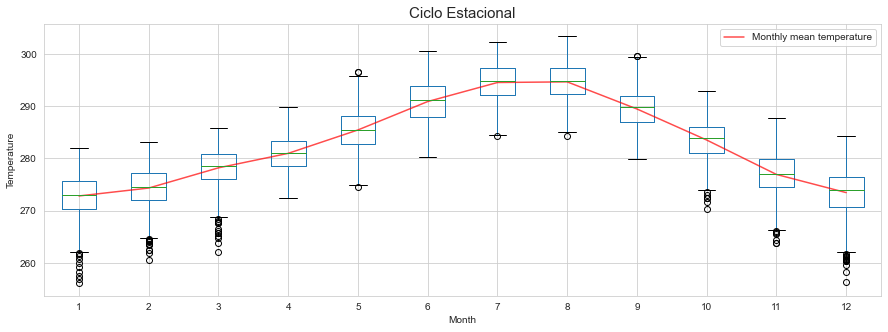

In [24]:
df_1=pd.concat(df_list, axis=1)

df_1.boxplot(figsize=(15,5))
plt.plot(list(range(1,13)), df_1.mean(), color='red',alpha=0.7,
         label = 'Monthly mean temperature')

plt.legend(loc='best')
plt.ylabel('Temperature')
plt.xlabel('Month')
plt.title('Ciclo Estacional',fontsize=15)

#### <span style='color:darkblue'>1.3.2 Caracterización para la distribución de Enero y Julio.</span>

orange
Stadistic data from January
Percentiles for the data in January are: q(5%)=265.51 and q(95%)= 279.38
Percentiles for the theoric distribution in January are: q(5%)=265.89 and q(95%)= 279.74
IC= [272.81+-0.27] (ºC)
With scipy function:(272.543879628045, 273.08575904383)
------------------------------------------------------------------------------
blue
Stadistic data from July
Percentiles for the data in July are: q(5%)=288.42 and q(95%)= 299.48
Percentiles for the theoric distribution in July are: q(5%)=288.81 and q(95%)= 300.31
IC= [294.56+-0.22] (ºC)
With scipy function:(294.33193832413974, 294.781770171954)
------------------------------------------------------------------------------


<function matplotlib.pyplot.legend(*args, **kwargs)>

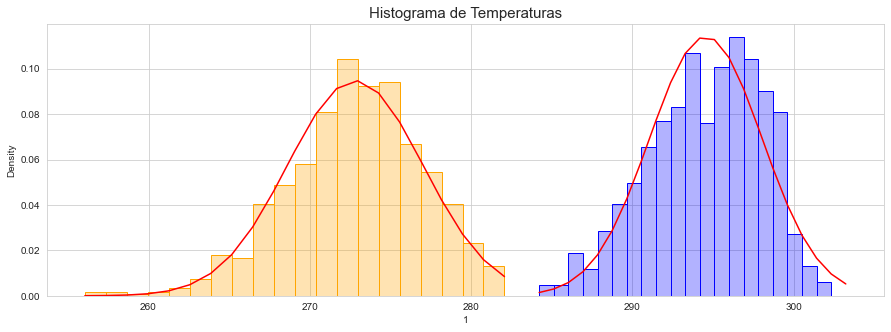

In [25]:
plt.figure(figsize=(15,5))

meses = [1,7]
colores = ['orange', 'blue']

for i in meses:
    # Creo una variable con los datos que quiero representar
    data = df_list[i-1][f'{i}']

    # Plot de histograma
    sns.histplot(data=data,color=colores[meses.index(i)], stat='density',
                bins=20, alpha=0.3, edgecolor=colores[meses.index(i)], 
                label = months_dic[i])
    print(colores[meses.index(i)])

    # Distribución normal sobre el histograma
    mean = data.mean()
    std  = data.std()
    n= np.shape(data)[0]
    
    minim = data.min()
    maxim = data.max()
    
    bins= np.arange(minim, maxim+1, step = (maxim - minim)/20) 
    
    normal_distribution= stats.norm.pdf(bins,mean,std)
    
    # Plot de la normal
    plt.plot(bins, normal_distribution, 'red',label=f'Theoric {months_dic[i]}')

    # Calculo de quantiles
    quantile_theoric = [stats.norm.ppf(0.05,mean,std),
                        stats.norm.ppf(0.95,mean,std)]
    
    # Print de los datos que tengo en los percentiles
    print(f'Stadistic data from {months_dic[i]}')
    print(f'Percentiles for the data in {months_dic[i]} are: q(5%%)=%.2f and q(95%%)= %.2f' %(data.quantile(q=0.05), data.quantile(q=0.95)))
    print(f'Percentiles for the theoric distribution in {months_dic[i]} are: q(5%%)=%.2f and q(95%%)= %.2f' %(quantile_theoric[0],quantile_theoric[1]))

    
    # Intervalo de confianza del 95%
    alfa=0.05
    
    # We must use the t-student distribution, beacuse with don't now the 
    # standard deviation of the data
    t_alpha_2= stats.t.ppf(1-alfa/2,n-1)
    ic= t_alpha_2*std/np.sqrt(n)
    print('IC= [%.2f+-%.2f] (ºC)'%(mean,ic))

    ic_scipy=stats.t.interval(alpha=0.95, df=n-1, loc=mean, scale=std/np.sqrt(n))
    print(f'With scipy function:{ic_scipy}')
    
    print('------------------------------------------------------------------------------')
    
# Cosas globales que quiero representar en el gráfico
plt.title('Histograma de Temperaturas',fontsize=15)
plt.legend

#### <span style='color:darkblue'>1.3.3 Análisis de la consistencia entre los datos de estación y del CPC Para enero y julio separadamente evalúa la consistencia de los datos.</span>

In [26]:
# Datos de CPC para enero
# Lo de ['numero'] lo pongo para que la salida sean un pandas series y no 
# dataframe
df_enero = df_list[0]['1']
df_julio = df_list[6]['7']

# Datos de la estacion
estacion_enero = isd_data[isd_data.month == 1]['temp']
estacion_julio = isd_data[isd_data.month == 7]['temp']

In [27]:
# Enero
alpha = 0.05
a = StadisticalTests(x=df_enero, y=estacion_enero, alpha  = alpha)
b = StadisticalTests(x=df_julio, y=estacion_julio, alpha = alpha)

In [28]:
# Enero
a.mean_test()
a.f_test_manual()

Se ha rechazado la hipotesis de que las medias son iguales con una confianza de 0.05.
Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de 0.05.


True

In [29]:
# Julio
b.mean_test()
b.f_test_manual()

Se ha rechazado la hipotesis de que las medias son iguales con una confianza de 0.05.
Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de 0.05.


True

## <span style="color:green">Apartado 2</span>:   

<span style='color:black'>En este apartado se pretende analizar la climatologia en invierno y verano de las temperaturas de la superficie del mar y obtener series temporales de la anomalía mensual en diversas regiones.</span>

### <span style='color:darkgreen'>2.1 Caracterización de la climatología invierno / verano</span>

In [4]:
folder = 'HadISST1'

# Voy a leer los datos usando xarray
ds=xr.open_dataset(f'data/{folder}/HadISST1_sst_1870-2019.nc')

# Calculate the mean and std
ds_mean = ds.groupby('time.season').mean()
ds_std =  ds.groupby('time.season').std()

Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

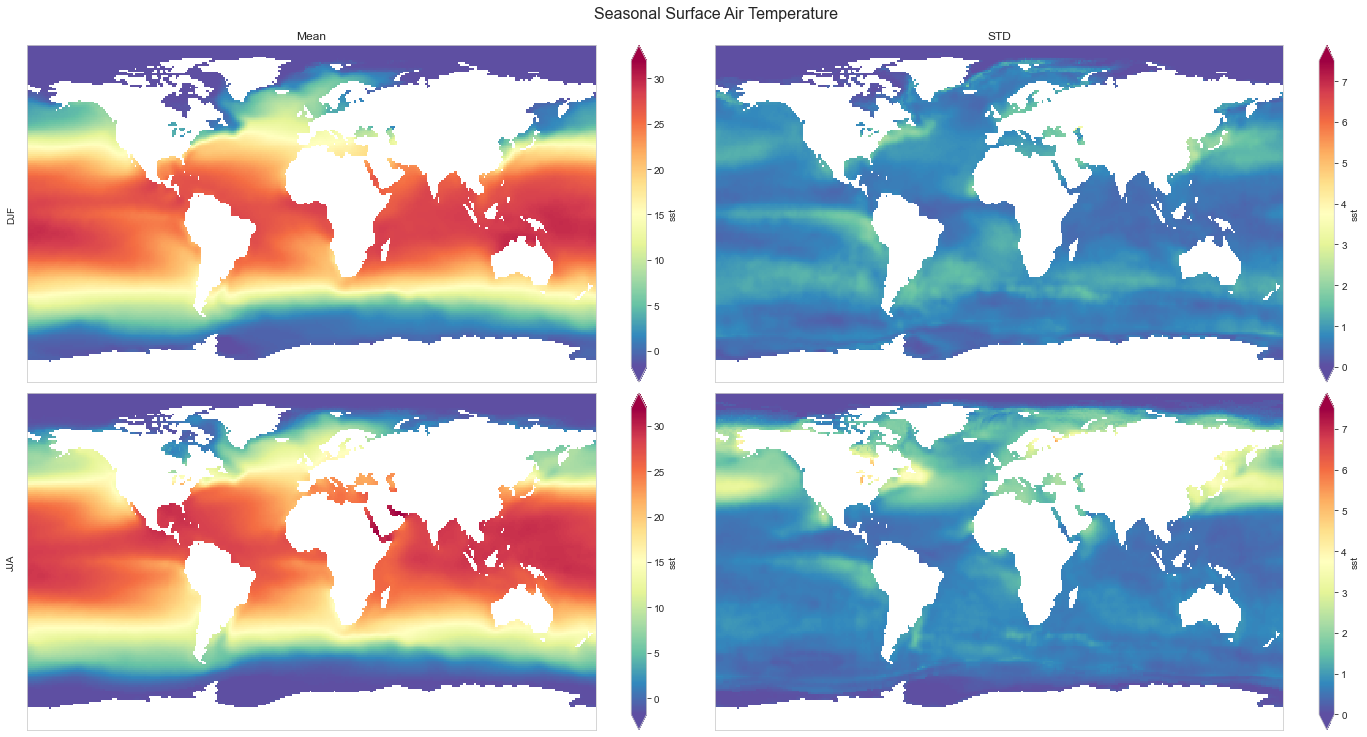

In [5]:
# Quick plot to show the results

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
for i, season in enumerate(("DJF","JJA")):
    ds_mean["sst"].sel(season=season).plot.pcolormesh(
        ax=axes[i, 0],
        vmin=ds_mean["sst"].min(),
        vmax=ds_mean["sst"].max(),
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )

    ds_std["sst"].sel(season=season).plot.pcolormesh(
        ax=axes[i, 1],
        vmin=ds_std["sst"].min(),
        vmax=ds_std["sst"].max(),
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )

    axes[i, 0].set_ylabel(season)
    axes[i, 1].set_ylabel("")

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

axes[0, 0].set_title("Mean")
axes[0, 1].set_title("STD")
axes[1, 0].set_title('')
axes[1, 1].set_title('')

plt.tight_layout()

fig.suptitle('Seasonal Surface Air Temperature', fontsize=16, y=1.02)

### <span style='color:darkgreen'>2.2 Calcula la media y la desviación típica en distintos periodos y representa varios maps.</span>

<div style='color:black'>Calcula la media y la desviación típica en el periodo 1870-1930, 1931-1975 y 1975-2019 y representa   
 
-  mapas de diferencia de medias '1976-2019 menos 1870-1930' y '1931-1975 menos 1870-
1930'. Indica con puntos las regiones donde ha habido un cambio significativo en la media a
un nivel de confianza del 95%
-  mapas de razón de varianzas '1976-2019 / 1870-1930' y '1931-1975 / 1870-1930'. Indica
con puntos las regiones donde ha habido un cambio significativo en la variabilidad a un
nivel de confianza del 95%

</div>

In [6]:
# Primer periodo
first_mean  = ds['sst'].sel(time=slice('1870', '1930')).mean(dim='time')
first_std   = ds['sst'].sel(time=slice('1870', '1930')).std(dim='time')

# Secondo periodo
second_mean = ds['sst'].sel(time=slice('1931', '1975')).mean(dim='time')
second_std  = ds['sst'].sel(time=slice('1931', '1975')).std(dim='time')

# Tercer periodo
thirth_mean = ds['sst'].sel(time=slice('1976', '2019')).mean(dim='time')
thirth_std  = ds['sst'].sel(time=slice('1976', '2019')).std(dim='time')

In [7]:
# Calculo de la diferencia de los periodos: primero - tercero
dif_1 = first_mean - thirth_mean

# Calculo de la diferencia de los periodos: segundo - primero
dif_2 = second_mean - thirth_mean

In [ ]:
dif_1_Z = abs(first_mean - thirth_mean)/(first_std/len(range(1870,1930)) + thirth_std/len(range(1976, 2019)))
dif_2_Z = abs(first_mean - second_mean)/(first_std/len(range(1870,1930)) + second_std/len(range(1931, 1975)))

# Caclulo el estadistico
alpha = 0.05
z_alpha_2 = stats.norm.ppf(1-alpha/2)

Text(0.5, 1.02, 'Mapa de diferencia de medias')

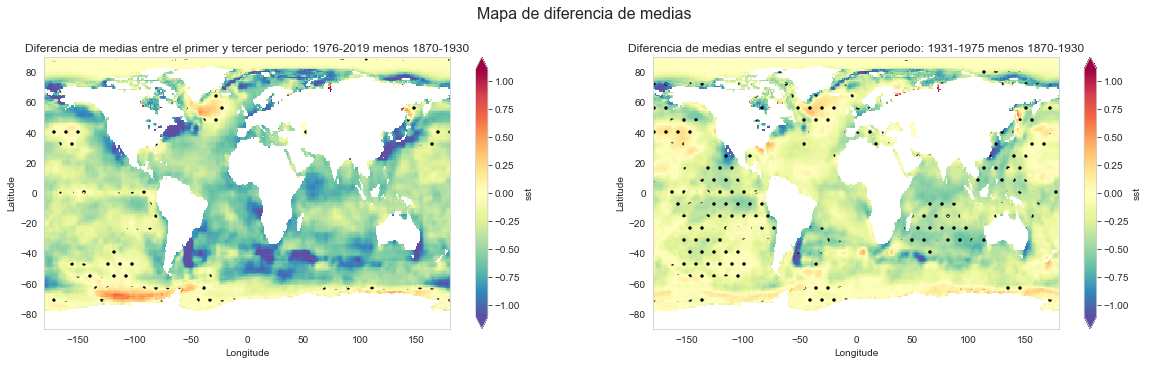

In [85]:
# Gráfica de las diferencias

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
dif_1.plot.pcolormesh(
        ax=axes[0],
        vmin=-1.1,
        vmax=1.1,
        cmap="Spectral_r",
        add_colorbar=True
    )
dif_1_Z.plot.contourf(ax = axes[0], levels = [0.0,z_alpha_2], 
                      hatches=['.', None], 
                      extend ='neither',colors='none',
                      add_colorbar=False)

dif_2.plot.pcolormesh(
        ax=axes[1],
        vmin=-1.1,
        vmax=1.1,
        cmap="Spectral_r",
        add_colorbar=True
        
    )

dif_2_Z.plot.contourf(ax = axes[1], levels = [0.0,z_alpha_2], 
                      hatches=['.', None], 
                      extend ='neither',colors='none',
                      add_colorbar=False)

# Poner nombres a los ejes
axes[0].set_ylabel('Latitude')
axes[1].set_ylabel('Latitude')

axes[0].set_xlabel('Longitude')
axes[1].set_xlabel('Longitude')

# Poner titulos a las gráficas
axes[0].set_title("Diferencia de medias entre el primer y tercer periodo: 1976-2019 menos 1870-1930")
axes[1].set_title("Diferencia de medias entre el segundo y tercer periodo: 1931-1975 menos 1870-1930")

fig.suptitle('Mapa de diferencia de medias', fontsize=16, y=1.02)

In [97]:
# Razón de varianzas
var_1 = thirth_std/first_std
var_2 = second_std/first_std

# Para quitar los valores que saturan mayores a 2
var_1= var_1.where(var_1<2)
var_2= var_2.where(var_2<2)

In [104]:
# Calculo del stadistico
f_1 = stats.f.interval(0.05 , len(range(1976, 2019)), len(range(1870, 1930)), loc=0, scale=1)
f_2 = stats.f.interval(0.05 , len(range(1976, 2019)), len(range(1931, 1975)), loc=0, scale=1)

Text(0.5, 1.02, 'Mapa de razon de varianzas')

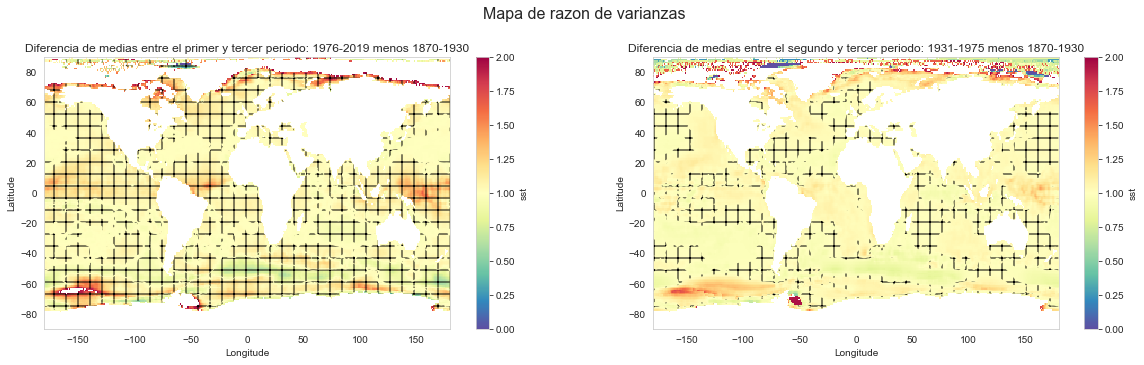

In [111]:
# np.clip(array, min, max)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
var_1.plot.pcolormesh(
        ax=axes[0],
        vmin=0,
        vmax=2,
        cmap="Spectral_r",
        add_colorbar=True
    )
var_1.plot.contourf(ax = axes[0], levels = f_1, 
                      hatches=['+', None], 
                      extend ='both',colors='none',
                      add_colorbar=False)

var_2.plot.pcolormesh(
        ax=axes[1],
        vmin=0,
        vmax=2,
        cmap="Spectral_r",
        add_colorbar=True
        
    )
var_2.plot.contourf(ax = axes[1], levels = f_2, 
                      hatches=['+'], 
                      extend ='neither',colors='none',
                      add_colorbar=False)

# Poner nombres a los ejes
axes[0].set_ylabel('Latitude')
axes[1].set_ylabel('Latitude')

axes[0].set_xlabel('Longitude')
axes[1].set_xlabel('Longitude')

# Poner titulos a las gráficas
axes[0].set_title("Diferencia de medias entre el primer y tercer periodo: 1976-2019 menos 1870-1930")
axes[1].set_title("Diferencia de medias entre el segundo y tercer periodo: 1931-1975 menos 1870-1930")

fig.suptitle('Mapa de razon de varianzas', fontsize=16, y=1.02)

### <span style='color:darkgreen'>2.3 Evaluación de las series temporales de anomalías en distintas regiones para el periodo completo.</span>